In [17]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import cv2
import importlib
import module.load_data
importlib.reload(module.load_data)

from module.load_data import load_dcm,load_mask

def process_images_for_patients(base_path, target_size,a =0):

    # 获取所有病人文件夹
    all_folders = sorted([f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))])

    # 按病人分组文件夹，每两个文件夹为一个病人
    patient_folders = []
    for i in range(0, len(all_folders), 2):
        
        if i + 1 < len(all_folders):
            patient_folders.append([all_folders[i], all_folders[i + 1]])
        
    # 加载每个文件夹中的图像
    patient_images = []
    masks = []

    for folder_pair in patient_folders:

        all_images = []
        for folder in folder_pair:
            a += 1

            dcm_file = None
            nii_file = None

            # print(folder)

            # 查找对应的 .dcm 和 .nii 文件
            for file in os.listdir(os.path.join(base_path, folder)):
                if file.endswith('.dcm'):
                    dcm_file = os.path.join(base_path, folder, file)
                elif file.endswith('.nii.gz'):
                    nii_file = os.path.join(base_path, folder, file)
                           
            # print(f"dcm_file: {dcm_file}, nii_file: {nii_file}")

            if dcm_file and nii_file:
                # 读取并处理 .dcm 和 .nii 图像
                dcm_image = load_dcm(dcm_file)
                nii_mask , top_left, bottom_right = load_mask(nii_file)
                dcm_image = dcm_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]

                # 将两个图像相乘
                focused_image = dcm_image * nii_mask
                focused_image = cv2.resize(focused_image, target_size)
                dcm_image = cv2.resize(dcm_image, target_size)  
                nii_mask = cv2.resize(nii_mask, target_size)                           
                
                patient_images.append(dcm_image)

                masks.append(nii_mask)

            else:
                dcm_image = load_dcm(dcm_file)
                dcm_image = cv2.resize(dcm_image, target_size)
                patient_images.append(dcm_image)
                masks.append(np.ones(target_size))
                

    return patient_images,masks
    

base_path = './data/chaoyang_huigu'  # 图像数据的根目录
save_path = './image'
target_size = (224, 224)  # 目标图像尺寸

patient_images,mask = process_images_for_patients(base_path, target_size)


/home/user/guyang/miniconda3/envs/mg/lib/python3.8/site-packages/pydicom/charset.py:754: UserWarning: Unknown encoding 'ISO 2022 IR 165' - using default encoding instead
  _warn_about_invalid_encoding(encoding)


In [19]:
from module.load_data import cache_dataset

# 缓存预处理后图像
cache_dataset(patient_images, 'cache/radiomics.npy', format='npy')
cache_dataset(mask, 'cache/radiomics_mask.npy', format='npy')

In [20]:
import importlib
import module.load_data
importlib.reload(module.load_data)

from module.load_data import load_cached_dataset

img_path = 'cache/radiomics.npy'
mask_path = 'cache/radiomics_mask.npy'
images = load_cached_dataset(img_path, format='npy')
masks = load_cached_dataset(mask_path, format='npy')

# print(images.shape)
# npimage = np.array(masks[0])
np.savetxt('./mask.txt',masks[0])

正在提取特征...
正在进行PCA降维...

原始特征数量: 42
PCA降维后特征数量: 7
累计解释方差比: 0.9566


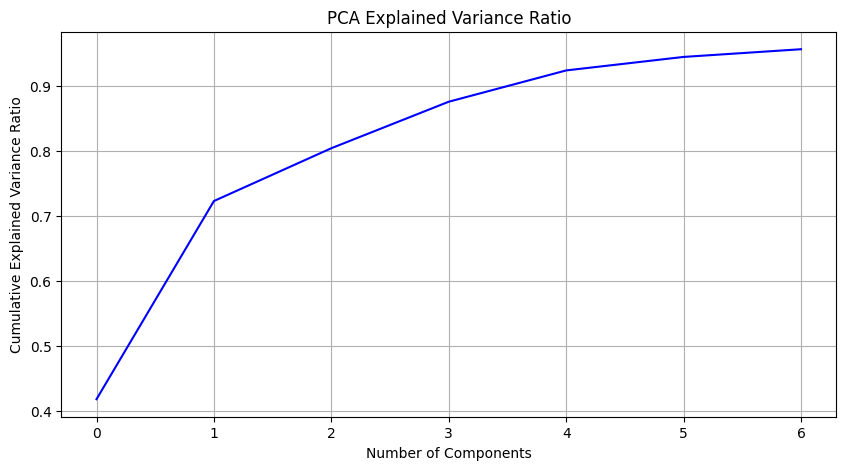

In [38]:
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage import measure
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def extract_features(image):
    """
    提取图像特征
    """
    features = {}
    
    # 1. 灰度特征
    features.update(extract_intensity_features(image))
    
    # 2. 纹理特征
    features.update(extract_glcm_features(image))
    
    # 3. 形态特征
    features.update(extract_shape_features(image))
    
    return features

def extract_intensity_features(image):
    """
    提取灰度特征
    """
    features = {}
    
    # 基本统计量
    features['mean'] = np.mean(image)
    features['std'] = np.std(image)
    features['variance'] = np.var(image)
    features['skewness'] = stats.skew(image.flatten())
    features['kurtosis'] = stats.kurtosis(image.flatten())
    
    # 灰度直方图统计
    hist, bins = np.histogram(image.flatten(), bins=256, range=(0, 1))
    features['hist_mean'] = np.mean(hist)
    features['hist_std'] = np.std(hist)
    features['hist_energy'] = np.sum(hist**2)
    features['hist_entropy'] = -np.sum(hist[hist>0] * np.log2(hist[hist>0]))
    
    return features

def extract_glcm_features(image):
    """
    提取GLCM纹理特征
    """
    features = {}
    
    # 将图像缩放到0-255范围用于GLCM计算
    img_scaled = (image * 255).astype(np.uint8)
    
    # 计算不同方向的GLCM
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    glcm = graycomatrix(img_scaled, distances, angles, levels=256, symmetric=True, normed=True)
    
    # 提取GLCM属性
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    
    for prop in properties:
        glcm_feature = graycoprops(glcm, prop)
        for i, angle in enumerate([0, 45, 90, 135]):
            features[f'glcm_{prop}_{angle}'] = glcm_feature[0, i]
    
    return features

def extract_shape_features(image):
    """
    提取形态特征
    """
    features = {}
    
    # 二值化图像
    threshold = np.mean(image)
    binary = (image > threshold).astype(np.uint8)
    
    # 提取区域属性
    regions = measure.regionprops(binary)
    
    if regions:
        region = regions[0]
        features['area'] = region.area
        features['perimeter'] = region.perimeter
        features['eccentricity'] = region.eccentricity
        features['solidity'] = region.solidity
        features['extent'] = region.extent
        features['circularity'] = 4 * np.pi * region.area / (region.perimeter ** 2) if region.perimeter > 0 else 0
        features['major_axis_length'] = region.major_axis_length
        features['minor_axis_length'] = region.minor_axis_length
        features['aspect_ratio'] = region.major_axis_length / region.minor_axis_length if region.minor_axis_length > 0 else 0
    else:
        # 如果没有检测到区域，填充默认值
        shape_features = ['area', 'perimeter', 'eccentricity', 'solidity', 'extent', 
                         'circularity', 'major_axis_length', 'minor_axis_length', 'aspect_ratio']
        for feature in shape_features:
            features[feature] = 0
    
    return features

def extract_all_features(images):
    """
    为所有图像提取特征
    """
    all_features = []
    feature_names = None
    
    for image in images:
        features = extract_features(image)
        if feature_names is None:
            feature_names = list(features.keys())
        all_features.append([features[name] for name in feature_names])
    
    return np.array(all_features), feature_names

def apply_pca(features, n_components=0.95):
    """
    应用PCA降维
    """
    # 标准化
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # PCA降维
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # 计算解释方差比
    explained_variance_ratio = pca.explained_variance_ratio_
    
    return features_pca, pca, scaler, explained_variance_ratio

# 1. 提取特征
print("正在提取特征...")
features, feature_names = extract_all_features(images)
# 2. 应用PCA
print("正在进行PCA降维...")
features_pca, pca, scaler, explained_variance_ratio = apply_pca(features)

# 3. 打印信息
print(f"\n原始特征数量: {features.shape[1]}")
print(f"PCA降维后特征数量: {features_pca.shape[1]}")
print(f"累计解释方差比: {np.sum(explained_variance_ratio):.4f}")

# # 4. 可视化主成分解释方差比
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5))
# plt.plot(np.cumsum(explained_variance_ratio), 'b-')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance Ratio')
# plt.title('PCA Explained Variance Ratio')
# plt.grid(True)
# plt.show()

数据集划分完成：
训练集大小: 326 (70.0%)
验证集大小: 70 (15.0%)
测试集大小: 70 (15.0%)

开始网格搜索最优参数...
Fitting 5 folds for each of 21 candidates, totalling 105 fits

最优参数：
C: 100
gamma: 0.1
kernel: rbf

Val分类报告：
              precision    recall  f1-score   support

         0.0       0.47      0.43      0.45        37
         1.0       0.42      0.45      0.43        33

    accuracy                           0.44        70
   macro avg       0.44      0.44      0.44        70
weighted avg       0.45      0.44      0.44        70



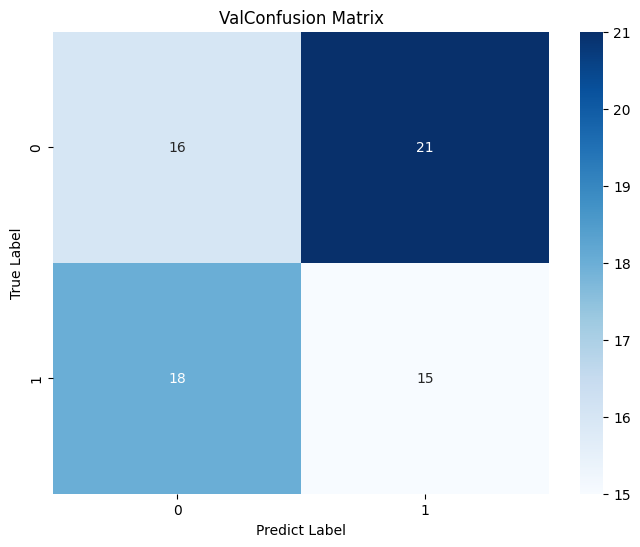


Test分类报告：
              precision    recall  f1-score   support

         0.0       0.63      0.45      0.52        38
         1.0       0.51      0.69      0.59        32

    accuracy                           0.56        70
   macro avg       0.57      0.57      0.55        70
weighted avg       0.58      0.56      0.55        70



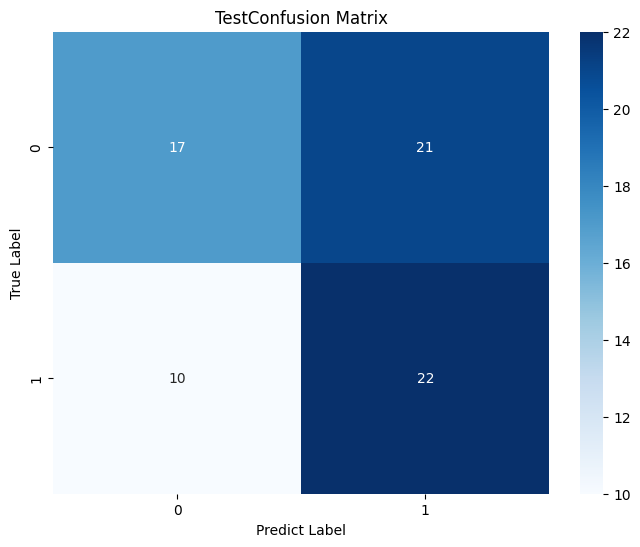

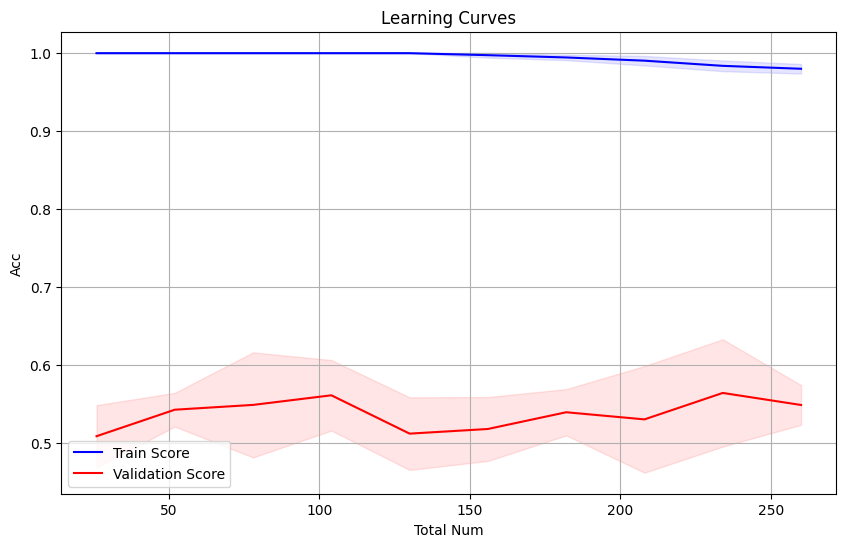

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import module.load_data
importlib.reload(module.load_data)
from module.load_data import get_labels


class ThyroidSVMClassifier:
    def __init__(self):
        self.svm = None
        self.best_params = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
    
    def split_data(self, features_pca, labels, random_state=42):
        """
        将数据划分为训练集(70%)、验证集(15%)和测试集(15%)
        """
        # 首先划分出测试集
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            features_pca, labels, test_size=0.15, random_state=random_state, stratify=labels
        )
        
        # 再将剩余数据划分为训练集和验证集
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=0.176, random_state=random_state, stratify=y_temp
        )
        
        print("数据集划分完成：")
        print(f"训练集大小: {self.X_train.shape[0]} ({self.X_train.shape[0]/features_pca.shape[0]:.1%})")
        print(f"验证集大小: {self.X_val.shape[0]} ({self.X_val.shape[0]/features_pca.shape[0]:.1%})")
        print(f"测试集大小: {self.X_test.shape[0]} ({self.X_test.shape[0]/features_pca.shape[0]:.1%})")
    
    def train_model(self):
        """
        训练SVM模型，包括参数网格搜索
        """
        # 定义参数网格
        param_grid = {
            'C': [0.001, 0.01,0.05 ,0.1, 1, 10, 100],
            # 'C': [1,5,10,15,20,50],
            'gamma': [0.1,0.5,1],
            # 'gamma': ['scale', 'auto'],
            'kernel': ['rbf'],
            # 'kernel': ['rbf','poly','sigmoid'],
            # 'degree': [2, 4],
            # 'class_weight': ['balanced'],
            # 'coef0': [0.0, 0.1, 1.0]

        }
        
        # 初始化基础SVM模型
        base_svm = SVC(random_state=42, probability=True)
        
        # 使用GridSearchCV进行参数搜索
        print("\n开始网格搜索最优参数...")
        grid_search = GridSearchCV(
            base_svm,
            param_grid,
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        
        # 在训练集上进行训练
        grid_search.fit(self.X_train, self.y_train)
        
        # 保存最优模型和参数
        self.svm = grid_search.best_estimator_
        self.best_params = grid_search.best_params_
        
        print("\n最优参数：")
        for param, value in self.best_params.items():
            print(f"{param}: {value}")
    
    def evaluate_model(self, dataset='validation'):
        """
        评估模型性能
        """
        if dataset == 'validation':
            X = self.X_val
            y = self.y_val
            dataset_name = "Val"
        else:
            X = self.X_test
            y = self.y_test
            dataset_name = "Test"
        
        # 预测概率和类别
        y_pred = self.svm.predict(X)
        y_prob = self.svm.predict_proba(X)
        
        # 打印分类报告
        print(f"\n{dataset_name}分类报告：")
        print(classification_report(y, y_pred))
        
        # 绘制混淆矩阵
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{dataset_name}Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predict Label')
        plt.show()
        
        return y_pred, y_prob
    
    def plot_learning_curves(self):
        """
        绘制学习曲线
        """
        from sklearn.model_selection import learning_curve
        
        train_sizes, train_scores, val_scores = learning_curve(
            self.svm, self.X_train, self.y_train,
            train_sizes=np.linspace(0.1, 1.0, 10),
            cv=5, n_jobs=-1, scoring='accuracy'
        )
        
        # 计算平均值和标准差
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # 绘制学习曲线
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, label='Train Score', color='blue')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        plt.plot(train_sizes, val_mean, label='Validation Score', color='red')
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
        plt.xlabel('Total Num')
        plt.ylabel('Acc')
        plt.title('Learning Curves')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

def main():
    # 加载数据
    excel_path = './data/beiyou_excel/chaoyang_retrospective_233.xlsx'  # 包含病人姓名和标签的Excel文件路径
    labels = get_labels(excel_path)
    
    # 创建分类器实例
    classifier = ThyroidSVMClassifier()   
    # 划分数据集
    classifier.split_data(features_pca, labels)
    # 训练模型
    classifier.train_model()  
    # 在验证集上评估模型
    classifier.evaluate_model('validation')  
    # 在测试集上评估模型
    classifier.evaluate_model('test')   
    # 绘制学习曲线
    classifier.plot_learning_curves()

if __name__ == "__main__":
    main()


In [47]:
import numpy as np
import SimpleITK as sitk
from radiomics import featureextractor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer

# 转换为 SimpleITK 图像
sitk_images = [sitk.GetImageFromArray(img) for img in images]
sitk_masks = [sitk.GetImageFromArray(mask) for mask in masks]

config_file = 'radiomics_config.yaml'  # 配置文件路径
settings = {}
settings['binWidth'] = 25
settings['resampledPixelSpacing'] = None  
settings['interpolator'] = sitk.sitkBSpline

extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
extractor.enableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
print("Enabled features:", extractor.enabledFeatures)
# 提取特征
features_list = []
for idx, (image, mask) in enumerate(zip(sitk_images, sitk_masks)):
    try:
        feature_dict = extractor.execute(image, mask)
        feature_dict['ImageID'] = idx  # 添加图像索引或其他标识符
        features_list.append(feature_dict)
    except Exception as e:
        print(f"Error processing image {idx}: {e}")

# 转换为 DataFrame
df_features = pd.DataFrame(features_list)

# 保存特征
df_features.to_csv('./cache/radiomics_features.csv', index=False)

print("Enabled features:", extractor.enabledFeatures)

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': [], 'shape2D': []}


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

KeyboardInterrupt: 